# Optimization with JuMP in Julia
<table>
<tr>
<td> <a href="http://www.sloansportsconference.com"><img src="figures/ssac.jpg" alt="SSAC" style="max-height: 150px;"/> </a></td>
<td> <a href="http://julialang.org"><img src="figures/julia.png" alt="Julia" style="max-height: 150px;"/></a></td>
 <td> <a href="https://github.com/JuliaOpt/JuMP.jl"><img src="figures/jump.png" alt="IJulia" style="max-height: 150px;"/></a></td>
<td> <a href="http://jupyter.org"><img src="figures/jupyter.png" alt="Jupyter" style="max-height: 150px;"/></a></td>
</tr></table>

### *Sebastien Martin*
PhD Candidate in Operations Research, MIT Sloan. 

**[http://sebmart.github.io](http://sebmart.github.io)**


-----------------------------------

This IJulia/Jupyter notebook is an introduction to the **Julia** language and its optimization package **JuMP**, with examples in Sports Analytics. The notebook was made for the 1-hour workshop *Optimization with JuMP in Julia* at the  [2018 MIT Sloan Sports Analytics Conference (SSAC2018)](http://www.sloansportsconference.com/), presented by Sebastien Martin.


It is distributed with OpenSource/MIT license, at [https://github.com/sebmart/optimization_jump_julia](https://github.com/sebmart/optimization_jump_julia).

The notebook features a quick overview of Julia and JuMP, with many links to more specific, thorough material. We hope readers will use this resource as a reference. It is also optimized to be presented as a slide-deck with [RISE](https://github.com/damianavila/RISE). It was built for Julia 0.6.

This notebook also includes open-source contributions from [Arthur Delarue](https://adelarue.github.io/) and [Miles Lubin](https://mlubin.github.io/).

-----------------------------------

To learn how to write Julia code and run this notebook by yourself, please refer to the Appendix 1, 2 and 3 at the end of this notebook.

____________________________________

To be able to run the code of this notebook, please install the packages:
- `Plots` (plotting)
- `PlotlyJS` (interactive plots)
- `DataFrames` (data containers)
- `Query` (to perform SQL-like data queries)
- `Distributions` (for complex random number generation)
- `JuMP` (for optimization formulations)
- `Gurobi` (commercial solver -- use `Cbc` if you do not have a Gurobi Licence)
- `Interact` (for interactive widgets in the notebook)

and run the following code to load the packages:

In [ ]:
using Plots, DataFrames, Distributions, JuMP, Gurobi, Interact, Query
plotlyjs()

# Following the presentation in real-time

- This notebook (and slides) are available at:

> **[sebmart.github.io/ssac2018](sebmart.github.io/ssac2018)**


# Section 1: Why Julia?

Quoting the [Julia website](http://julialang.org):
> Julia is a **high-level**, **high-performance** **dynamic** programming language for **technical computing**, with syntax that is familiar to users of other technical computing environments. It provides a sophisticated compiler, distributed parallel execution, numerical accuracy, and an extensive mathematical function library.

A **high-level** language:

- Easy to use and learn, with a similar syntax to Python/Matlab. 
- It is possible to do complicated computations quickly.

For example, to get the sum of all the squares of all the numbers than 1 million:

In [6]:
sum(n^2 for n in 1:1_000_000)

333333833333500000

A **dynamic** language:

- Julia is, like Python, Matlab or R, a dynamic language: you can interact with the language without the need to compile your code. It is easy to use it for prototyping or presenting results.

A **high-performance** language: Julia is fast. Vanilla Julia code can reach performance comparable to C and Fortran (i.e., **very fast**).
<a href="http://nbviewer.jupyter.org/url/julialang.org/benchmarks/benchmarks.ipynb"><img src="figures/Julia-benchmarks.png" alt="Julia" style="width: 1500px;"/></a>

A language for **technical computing**:
- Julia has a lot of built in functions for **scientific** computing.
- A growing number of **packages**, mostly written in Julia itself.
- Powerful **editors** like *Jupyter* (used for this presentation)
- More and more users in **Finance, Biology, Optimization, Analytics**...


> Julia is a perfect compagnon for **Sports Analytics**


In [7]:
x = y = linspace(-15,15,100)
f(x,y) = sin(sqrt(x^2+y^2))/sqrt(x^2+y^2)
plot(x,y,f,st=:surface, legend=false, size=(800,600))

# Section 2: Optimization and JuMP

Analytics allows us to make sense of Big Data, and to build strong predictive models.

But the time comes when decisions need to be made that take into account these insights and predictions, **Optimization** is the field that matters.

<img src="figures/datascience-1.svg" alt="datascience diagram part 1" style="max-height: 800px;"/>

<img src="figures/datascience-2.svg" alt="datascience diagram part 2" style="max-height: 800px;"/>

## Sports Decisions
Sports Analytics can help making a lot of important decisions
- **Scheduling** games (what teams, when)
- **Choosing** team players (also for fantasy games)
- Pitching order in baseball, substitution **strategy** in basketball...
- **Personalized** training and nutrition.

## Optimization Formulations
<img src="figures/optimization.svg" alt="decisions constraints objective" style="max-height: 800px;"/>
- **Convex/Linear Optimization**: "easy" to solve, but limited modeling power.
- **Integer Optimization**: make choices between different possibilities, hard but more powerful.

An optimization problem is defined by:
- *decision variables*, "What are the values I want to find?"
- *constraints*, "What are the rules and constraints that limit my choice of decision variables?"
- *objective*, "What is my goal, what quantity do I want to maximize/minimize?"

<img src="figures/JuMP.svg" alt="decisions" style="max-height: 800px;"/>


# Section 3: Application, *Building a team*

We discover the use of JuMP for optimization with the simple task of picking 5 players to create a team.

Creating the fake data:

In [8]:
srand(4) # setting the random seed for reproducable results
players = DataFrame()
players[:Name] = ["Anna","Benjamin","Charlotte","Daniel","Emma","Francisco","Grace","Hunter","Isabella","Jacob","Kaylee","Liam","Mia","Noah","Olivia","Parker","Quinn","Ryan","Sophia","Thomas","Ursula","Vincent","Willow","Xavier","Yaretzi","Zachary"]
players[:Performance] = rand(Exponential(1), nrow(players))
players[:Performance] = round.(Int, players[:Performance] * 100 / maximum(players[:Performance]))
players[:Cost] = round.(Int,rand(LogNormal(0,0.2), nrow(players)).*players[:Performance]) * 10_000
players

,Name,Performance,Cost
1,Anna,45,610000
2,Benjamin,27,230000
3,Charlotte,64,770000
4,Daniel,25,330000
5,Emma,25,250000
6,Francisco,19,220000
7,Grace,2,20000
8,Hunter,51,410000
9,Isabella,29,330000
10,Jacob,39,480000


## The data
- **26 players**.
- Each player has a **cost**.
- We have a limited **budget**.
- Our Analytics team gave us a **performance** forecast for each player.

Let's use JuMP to **build the best team** of 5.
(maximum total performance within the budget)


In [9]:
players

,Name,Performance,Cost
1,Anna,45,610000
2,Benjamin,27,230000
3,Charlotte,64,770000
4,Daniel,25,330000
5,Emma,25,250000
6,Francisco,19,220000
7,Grace,2,20000
8,Hunter,51,410000
9,Isabella,29,330000
10,Jacob,39,480000


## Decisions
First, one decision for each player : should the player be in the team? 1 = YES, 0 = NO

In [10]:
m = Model(solver=GurobiSolver())
@variable(m, choosePlayer[1:nrow(players)], Bin)

26-element Array{JuMP.Variable,1}:
 choosePlayer[1] 
 choosePlayer[2] 
 choosePlayer[3] 
 choosePlayer[4] 
 choosePlayer[5] 
 choosePlayer[6] 
 choosePlayer[7] 
 choosePlayer[8] 
 choosePlayer[9] 
 choosePlayer[10]
 choosePlayer[11]
 choosePlayer[12]
 choosePlayer[13]
 choosePlayer[14]
 choosePlayer[15]
 choosePlayer[16]
 choosePlayer[17]
 choosePlayer[18]
 choosePlayer[19]
 choosePlayer[20]
 choosePlayer[21]
 choosePlayer[22]
 choosePlayer[23]
 choosePlayer[24]
 choosePlayer[25]
 choosePlayer[26]

## Constraints
- We need to choose **exactly 5 players**.
- We need to respect a **budget**. (here 1M dollars)

In [11]:
@constraint(m, teamwith5players, sum(choosePlayer) == 5)

choosePlayer[1] + choosePlayer[2] + choosePlayer[3] + choosePlayer[4] + choosePlayer[5] + choosePlayer[6] + choosePlayer[7] + choosePlayer[8] + choosePlayer[9] + choosePlayer[10] + choosePlayer[11] + choosePlayer[12] + choosePlayer[13] + choosePlayer[14] + choosePlayer[15] + choosePlayer[16] + choosePlayer[17] + choosePlayer[18] + choosePlayer[19] + choosePlayer[20] + choosePlayer[21] + choosePlayer[22] + choosePlayer[23] + choosePlayer[24] + choosePlayer[25] + choosePlayer[26] = 5

In [12]:
BUDGET = 1_000_000 # budget of 1 million dollars
@constraint(m, budgetconstraint, sum(choosePlayer[p]*players[p,:Cost] for p in 1:nrow(players)) <= BUDGET)

610000 choosePlayer[1] + 230000 choosePlayer[2] + 770000 choosePlayer[3] + 330000 choosePlayer[4] + 250000 choosePlayer[5] + 220000 choosePlayer[6] + 20000 choosePlayer[7] + 410000 choosePlayer[8] + 330000 choosePlayer[9] + 480000 choosePlayer[10] + 90000 choosePlayer[11] + 60000 choosePlayer[12] + 80000 choosePlayer[13] + 1.01e6 choosePlayer[14] + 140000 choosePlayer[15] + 140000 choosePlayer[16] + 110000 choosePlayer[17] + 210000 choosePlayer[18] + 200000 choosePlayer[19] + 320000 choosePlayer[20] + 70000 choosePlayer[21] + 300000 choosePlayer[22] + 170000 choosePlayer[23] + 100000 choosePlayer[24] + 260000 choosePlayer[25] + 260000 choosePlayer[26] ≤ 1.0e6

## Objective
We want to maximize the sum of the performance of our 5 players.

In [13]:
@objective(m, Max, sum(choosePlayer[p]*players[p,:Performance] for p in 1:nrow(players)))

45 choosePlayer[1] + 27 choosePlayer[2] + 64 choosePlayer[3] + 25 choosePlayer[4] + 25 choosePlayer[5] + 19 choosePlayer[6] + 2 choosePlayer[7] + 51 choosePlayer[8] + 29 choosePlayer[9] + 39 choosePlayer[10] + 7 choosePlayer[11] + 8 choosePlayer[12] + 9 choosePlayer[13] + 100 choosePlayer[14] + 15 choosePlayer[15] + 11 choosePlayer[16] + 12 choosePlayer[17] + 24 choosePlayer[18] + 25 choosePlayer[19] + 36 choosePlayer[20] + 8 choosePlayer[21] + 26 choosePlayer[22] + 26 choosePlayer[23] + 9 choosePlayer[24] + 23 choosePlayer[25] + 30 choosePlayer[26]

Let's look at the results!

In [14]:
solve(m)

Optimize a model with 2 rows, 26 columns and 52 nonzeros
Variable types: 0 continuous, 26 integer (26 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+06]
Found heuristic solution: objective 78
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 2 rows, 25 columns, 49 nonzeros
Variable types: 0 continuous, 25 integer (25 binary)

Root relaxation: objective 1.286875e+02, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  128.68750    0    2   78.00000  128.68750  65.0%     -    0s
H    0     0                     125.0000000  128.68750  2.95%     -    0s
     0     0  128.42105    0    2  125.00000  128.42105  2.74%     -    0s
H    0     0                     126.0000000  128.08000  1.65%     -    0s
     0     0  1

:Optimal

In [15]:
bestTeam = players[[p for p in 1:nrow(players) if getvalue(choosePlayer[p]) == 1],:]

,Name,Performance,Cost
1,Hunter,51,410000
2,Mia,9,80000
3,Olivia,15,140000
4,Sophia,25,200000
5,Willow,26,170000


In [16]:
bestTeam

,Name,Performance,Cost
1,Hunter,51,410000
2,Mia,9,80000
3,Olivia,15,140000
4,Sophia,25,200000
5,Willow,26,170000


In [17]:
println("Total Cost: \$", sum(bestTeam[:Cost]))
println("Total Performance: ", sum(bestTeam[:Performance]))

Total Cost: $1000000
Total Performance: 126


Let's put all of this together

In [77]:
function choosePlayers(players, budget)
    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, choosePlayer[1:nrow(players)], Bin)
    @constraint(m, teamwith5players, sum(choosePlayer) == 5)
    @constraint(m, budgetconstraint, sum(choosePlayer[p]*players[p,:Cost] for p in 1:nrow(players)) <= budget)
    @objective(m, Max, sum(choosePlayer[p]*players[p,:Performance] for p in 1:nrow(players)))
    if solve(m, suppress_warnings=true) != :Optimal
        return players[Int[],:] # returns nothing if infeasible
    else
        return players[[p for p in 1:nrow(players) if getvalue(choosePlayer[p]) == 1],:]
    end 
end
budgets = 100_000*(1:50)
bestteams = [choosePlayers(players, budget) for budget in budgets];

Let's play with the budget!

In [78]:
@manipulate for budget in 100_000*(1:50)
    myteam = deepcopy(bestteams[findfirst(budgets,budget)])
    push!(myteam, ["Total", sum(myteam[:Performance]), sum(myteam[:Cost])])
    myteam
end

Interact.Options{:SelectionSlider,Any}(5: "input-2" = 2500000 Any , "budget", 2500000, "2500000", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("100000"=>100000,"200000"=>200000,"300000"=>300000,"400000"=>400000,"500000"=>500000,"600000"=>600000,"700000"=>700000,"800000"=>800000,"900000"=>900000,"1000000"=>1000000…), Dict{Any,Any}(Pair{Any,Any}(3300000, "3300000"),Pair{Any,Any}(1000000, "1000000"),Pair{Any,Any}(4300000, "4300000"),Pair{Any,Any}(800000, "800000"),Pair{Any,Any}(4700000, "4700000"),Pair{Any,Any}(2400000, "2400000"),Pair{Any,Any}(1400000, "1400000"),Pair{Any,Any}(2800000, "2800000"),Pair{Any,Any}(4800000, "4800000"),Pair{Any,Any}(5000000, "5000000")…)), Any[], Any[], true, "horizontal")

,Name,Performance,Cost
1,Charlotte,64,770000
2,Hunter,51,410000
3,Noah,100,1010000
4,Olivia,15,140000
5,Willow,26,170000
6,Total,256,2500000


In [21]:
performances = [sum(team[:Performance]) for team in bestteams]
plot(budgets, performances, lw=3, ylims = (0,350), label="", xlabel="Budget (dollars)", ylabel="Performance", size=(800,400))

## In practice
- This "vanilla" problem is a famous optimization problem called the **knapsack problem**.
- **More constraints** (type of players, more complex objective...) can make it useful in practice.
- Such strategies have been successfully used to win at **fantasy sports**. See [SACC2017](https://www.youtube.com/watch?v=S7DN7ThD5mM) talk by MIT professor Tauhid Zaman about fantasy baseball.

# Section 4: Application, *NFL Scheduling*

A more advanced optimization example using JuMP, with the scheduling of the NFL 2018 regular season.

In [23]:
weeks = 1:17

teams = ["Eagles", "Vikings", "Saints", "Rams", "Cowboys", "Lions", "Panthers", "Seahawks", "Redskins", "Packers",
    "Falcons", "Cardinals", "Giants", "Bears", "Buccaneers", "49ers", "Patriots", "Steelers", "Jaguars", "Chiefs",
    "Bills", "Ravens", "Titans", "Chargers", "Dolphins", "Bengals", "Colts", "Raiders", "Jets", "Browns", "Texans", 
    "Broncos"]
games = [
("Bills","Bears"), ("Bills","Lions"), ("Bills","Jaguars"), ("Bills","Chargers"), ("Bills","Dolphins"), ("Bills","Patriots"), ("Bills","Jets"), ("Bills","Titans"),
("Dolphins","Bills"), ("Dolphins","Bears"), ("Dolphins","Lions"), ("Dolphins","Jaguars"), ("Dolphins","Patriots"), ("Dolphins","Jets"), ("Dolphins","Raiders"), ("Dolphins","Titans"), 
("Patriots","Bills"), ("Patriots","Packers"), ("Patriots","Texans"), ("Patriots","Colts"), ("Patriots","Dolphins"), ("Patriots","Vikings"), ("Patriots","Jets"), ("Patriots","Chiefs"),
("Jets","Bills"), ("Jets","Broncos"), ("Jets","Packers"), ("Jets","Texans"), ("Jets","Colts"), ("Jets","Dolphins"), ("Jets","Vikings"), ("Jets","Patriots"), 

("Ravens","Bills"), ("Ravens","Bengals"), ("Ravens","Browns"), ("Ravens","Broncos"), ("Ravens","Saints"), ("Ravens","Raiders"), ("Ravens","Steelers"), ("Ravens","Buccaneers"),   
("Bengals","Ravens"), ("Bengals","Browns"), ("Bengals","Broncos"), ("Bengals","Dolphins"), ("Bengals","Saints"), ("Bengals","Raiders"), ("Bengals","Steelers"), ("Bengals","Buccaneers"),
("Browns","Falcons"), ("Browns","Ravens"), ("Browns","Panthers"), ("Browns","Bengals"), ("Browns","Chiefs"), ("Browns","Chargers"), ("Browns","Jets"), ("Browns","Steelers"), 
("Steelers","Falcons"), ("Steelers","Ravens"), ("Steelers","Panthers"), ("Steelers","Bengals"), ("Steelers","Browns"), ("Steelers","Chiefs"), ("Steelers","Chargers"), ("Steelers","Patriots"),
    
("Texans","Bills"), ("Texans","Browns"), ("Texans","Cowboys"), ("Texans","Colts"), ("Texans","Jaguars"), ("Texans","Dolphins"), ("Texans","Giants"), ("Texans","Titans"),
("Colts","Bills"), ("Colts","Bengals"), ("Colts","Cowboys"), ("Colts","Texans"), ("Colts","Jaguars"), ("Colts","Dolphins"), ("Colts","Giants"), ("Colts","Titans"),  
("Jaguars","Texans"), ("Jaguars","Colts"), ("Jaguars","Patriots"), ("Jaguars","Jets"), ("Jaguars","Eagles"), ("Jaguars","Steelers"), ("Jaguars","Titans"), ("Jaguars","Redskins"),
("Titans","Ravens"), ("Titans","Texans"), ("Titans","Colts"), ("Titans","Jaguars"), ("Titans","Patriots"), ("Titans","Jets"), ("Titans","Eagles"), ("Titans","Redskins"), 
    
("Broncos","Browns"), ("Broncos","Texans"), ("Broncos","Chiefs"), ("Broncos","Chargers"), ("Broncos","Rams"), ("Broncos","Raiders"), ("Broncos","Steelers"), ("Broncos","Seahawks"), 
("Chiefs","Cardinals"), ("Chiefs","Ravens"), ("Chiefs","Bengals"), ("Chiefs","Broncos"), ("Chiefs","Jaguars"), ("Chiefs","Chargers"), ("Chiefs","Raiders"), ("Chiefs","49ers"),
("Chargers","Cardinals"), ("Chargers","Ravens"), ("Chargers","Bengals"), ("Chargers","Broncos"), ("Chargers","Chiefs"), ("Chargers","Raiders"), ("Chargers","49ers"), ("Chargers","Titans"),
("Raiders","Browns"), ("Raiders","Broncos"), ("Raiders","Colts"), ("Raiders","Chiefs"), ("Raiders","Chargers"), ("Raiders","Rams"), ("Raiders","Steelers"), ("Raiders","Seahawks"), 
    
("Cowboys","Lions"), ("Cowboys","Jaguars"), ("Cowboys","Saints"), ("Cowboys","Giants"), ("Cowboys","Eagles"), ("Cowboys","Buccaneers"), ("Cowboys","Titans"), ("Cowboys","Redskins"), 
("Giants","Bears"), ("Giants","Cowboys"), ("Giants","Jaguars"), ("Giants","Saints"), ("Giants","Eagles"), ("Giants","Buccaneers"), ("Giants","Titans"), ("Giants","Redskins"),   
("Eagles","Falcons"), ("Eagles","Panthers"), ("Eagles","Cowboys"), ("Eagles","Texans"), ("Eagles","Colts"), ("Eagles","Vikings"), ("Eagles","Giants"), ("Eagles","Redskins"), 
("Redskins","Falcons"), ("Redskins","Panthers"), ("Redskins","Cowboys"), ("Redskins","Packers"), ("Redskins","Texans"), ("Redskins","Colts"), ("Redskins","Giants"), ("Redskins","Eagles"), 
    
("Bears","Lions"), ("Bears","Packers"), ("Bears","Rams"), ("Bears","Vikings"), ("Bears","Patriots"), ("Bears","Jets"), ("Bears","Seahawks"), ("Bears","Buccaneers"), 
("Lions","Panthers"), ("Lions","Bears"), ("Lions","Packers"), ("Lions","Rams"), ("Lions","Vikings"), ("Lions","Patriots"), ("Lions","Jets"), ("Lions","Seahawks"),
("Packers","Cardinals"), ("Packers","Falcons"), ("Packers","Bills"), ("Packers","Bears"), ("Packers","Lions"), ("Packers","Dolphins"), ("Packers","Vikings"), ("Packers","49ers"), 
("Vikings","Cardinals"), ("Vikings","Bills"), ("Vikings","Bears"), ("Vikings","Lions"), ("Vikings","Packers"), ("Vikings","Dolphins"), ("Vikings","Saints"), ("Vikings","49ers"),

("Falcons","Cardinals"), ("Falcons","Ravens"), ("Falcons","Panthers"), ("Falcons","Bengals"), ("Falcons","Cowboys"), ("Falcons","Saints"), ("Falcons","Giants"), ("Falcons","Buccaneers"), 
("Panthers","Falcons"), ("Panthers","Ravens"), ("Panthers","Bengals"), ("Panthers","Cowboys"), ("Panthers","Saints"), ("Panthers","Giants"), ("Panthers","Seahawks"), ("Panthers","Buccaneers"), 
("Saints","Falcons"), ("Saints","Panthers"), ("Saints","Browns"), ("Saints","Rams"), ("Saints","Eagles"), ("Saints","Steelers"), ("Saints","Buccaneers"), ("Saints","Redskins"),
("Buccaneers","Falcons"), ("Buccaneers","Panthers"), ("Buccaneers","Browns"), ("Buccaneers","Saints"), ("Buccaneers","Eagles"), ("Buccaneers","Steelers"), ("Buccaneers","49ers"), ("Buccaneers","Redskins"), 
    
("Cardinals","Bears"), ("Cardinals","Broncos"), ("Cardinals","Lions"), ("Cardinals","Rams"), ("Cardinals","Raiders"), ("Cardinals","49ers"), ("Cardinals","Seahawks"), ("Cardinals","Redskins"),
("Rams","Cardinals"), ("Rams","Packers"), ("Rams","Chiefs"), ("Rams","Chargers"), ("Rams","Vikings"), ("Rams","Eagles"), ("Rams","49ers"), ("Rams","Seahawks"), 
("49ers","Cardinals"), ("49ers","Bears"), ("49ers","Broncos"), ("49ers","Lions"), ("49ers","Rams"), ("49ers","Giants"), ("49ers","Raiders"), ("49ers","Seahawks"),
("Seahawks","Cardinals"), ("Seahawks","Cowboys"), ("Seahawks","Packers"), ("Seahawks","Chiefs"), ("Seahawks","Chargers"), ("Seahawks","Rams"), ("Seahawks","Vikings"), ("Seahawks","49ers"),
]

# building a dictionary that associate each team with the games that they will play
gamesOfTeam = Dict(team=> Tuple{String,String}[] for team in teams)
for game in games
    (team1,team2) = game
    push!(gamesOfTeam[team1], game)
    push!(gamesOfTeam[team2], game)
end

srand(1) # to get reproducible results for the randomly generated data
gameInterest = Dict(game=>rand(Exponential(1)) for game in games)
maxInterest = maximum(values(gameInterest))

# For each game, gives an interest score (integer between 0 and 100)
gameInterest = Dict(game=>round(Int,gameInterest[game]*100/maxInterest) for game in games)

gamePreference = Dict((game, week)=>rand(Exponential(1)) for game in games, week in weeks)
maxPref = maximum(values(gamePreference))

# For each game/week pair, gives a preference score (integer between 0 and 100)
gamePreference = Dict((game, week)=>round(Int,gamePreference[game,week]*100/maxPref) for game in games, week in weeks)

# Putting all of this data together in a nice dataset
NFL2018games = DataFrame()
NFL2018games[:Home] = [team1 for (team1, _) in games]
NFL2018games[:Away] = [team2 for (_, team2) in games];
NFL2018games[:Interest] = [gameInterest[game] for game in games]
gamePreference
for week in weeks
   NFL2018games[Symbol("prefW$week")] = [gamePreference[game,week] for game in games]
end

## Setting
2018 NFL scheduling (simplified) problem

- **32 teams**.
- **256** games (16 per team)
- **17 weeks**, no more than 1 game per week per team.
- **1 Sunday Night** game each week.

*When should each game be played?*

## Data
- Estimated **Interest** for each game (potential TV revenues)
- Scheduling **preferences** for each game.
Scores between 0 and 100.
> *We made up the data, you can expect surprising results*

We want to :
- Put **high interest games on Sunday night**
- As a second objective, follow **teams preferences**.

- `Interest` is a score that represents the potential television audience, between 0 and 100 with a mean of 10. 
It is used to select which game should be played on Sunday Nights
- Weekly preferences for each game: a score that represents the preferences of the League for setting the game at different weeks. Between 0 and 100 with a mean of 10.

In [24]:
NFL2018games

,Home,Away,Interest,prefW1,prefW2,prefW3,prefW4,prefW5,prefW6,prefW7,prefW8,prefW9,prefW10,prefW11,prefW12,prefW13,prefW14,prefW15,prefW16,prefW17
1,Bills,Bears,12,42,1,17,7,9,21,5,3,0,21,22,1,16,11,5,9,5
2,Bills,Lions,13,15,6,4,7,5,14,12,18,2,2,15,4,21,34,1,2,13
3,Bills,Jaguars,9,4,14,12,3,9,13,14,2,6,24,14,9,14,0,37,5,7
4,Bills,Chargers,0,93,2,1,7,9,7,21,9,10,7,1,9,4,14,12,3,19
5,Bills,Dolphins,9,5,4,21,16,3,17,8,36,17,5,1,5,0,29,9,4,3
6,Bills,Patriots,19,16,15,13,9,1,40,2,3,8,10,9,46,2,6,10,13,8
7,Bills,Jets,55,5,5,3,15,31,16,7,14,16,9,2,0,24,4,11,18,1
8,Bills,Titans,51,1,16,12,6,2,4,0,3,14,6,1,0,3,14,1,3,12
9,Dolphins,Bills,15,6,9,14,19,0,10,15,19,30,18,3,43,5,12,10,9,6
10,Dolphins,Bears,12,6,15,15,1,13,17,1,16,20,14,11,17,11,8,21,15,4


## Decision Variables:
- For each game `g` and week `w`, `gameAtWeek[g,w] == 1` if the game `g` is schedule week `w`.
- For each game `g` and week `w`, `sundayNightGame[g,w] == 1` if the game `g` is schedule week `w` AND is played on Sunday night.

In [28]:
m = Model(solver=GurobiSolver())
@variable(m, gameAtWeek[games,weeks], Bin)
@variable(m, sundayNightGame[games, weeks], Bin)

sundayNightGame[i,j] ∈ {0,1} ∀ i ∈ {("Bills", "Bears"),("Bills", "Lions"),…,("Seahawks", "Vikings"),("Seahawks", "49ers")}, j ∈ {1,2,…,16,17}

## Constraints
- No more than **one game each week per team** (each team has 1 week off).
- Each game has to be played and played only once.
- **Only one Sunday night game** each week.
- A game can be the week's Sunday night's game only if it is played that week.

In [29]:
@constraint(m, maxOneGamePerTeamPerWeek[team in teams, week in weeks], sum(gameAtWeek[game, week] for game in gamesOfTeam[team]) <= 1)
@constraint(m, eachGameIsPlayedOnce[game in games], sum(gameAtWeek[game,week] for week in weeks) == 1)
@constraint(m, oneSundayNightPerWeek[week in weeks], sum(sundayNightGame[game, week] for game in games) == 1)
@constraint(m, sundayGameIsPlanned[game in games, week in weeks], sundayNightGame[game, week] <= gameAtWeek[game, week]);

# Objective
- The schedule should put game with **high interest on Sunday Nights**.
- Additionally, maximize the **preferences** associated with each game time.

In [30]:
@objective(m, Max, 
    sum( 1000 * sundayNightGame[game,week] * gameInterest[game] +
         1    * gamePreference[game,week]  * gameAtWeek[game,week]
        for game in games, week in weeks));  

## Solving
- Very hard problem: **8704 decisions** to be made!
- State of the art solvers can nonetheless find the very best solution (~**3 minutes** on this computer)

In [31]:
solve(m)

Optimize a model with 5169 rows, 8704 columns and 26112 nonzeros
Variable types: 0 continuous, 8704 integer (8704 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 430920
Presolve time: 0.05s
Presolved: 5169 rows, 8704 columns, 26112 nonzeros
Variable types: 0 continuous, 8704 integer (8704 binary)

Root relaxation: objective 1.177935e+06, 3327 iterations, 0.91 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1177935.37    0  654 430920.000 1177935.37   173%     -    0s
H    0     0                    1092885.0000 1177935.37  7.78%     -    1s
H    0     0                    1140749.0000 1177935.37  3.26%     -    1s
H    0     0                    1177389.0000 1177935.37  0.05%     -    1s
     0     0 1177930.3

:Optimal

- Run the following code to get the results from the solver, format them and put them in a nice dataset.

In [33]:
scheduledGames = DataFrame()
scheduledGames[:Home] = NFL2018games[:Home]
scheduledGames[:Away] = NFL2018games[:Away]
gameWeek = Int[]
sundayNight = Int[]
prefScore = Int[]
for i in 1:nrow(scheduledGames)
    home = scheduledGames[i, :Home]
    away = scheduledGames[i, :Away]
    week = indmax(getvalue(gameAtWeek[(home,away),week]) for week in weeks)
    push!(gameWeek,week)
    isSundayNight = maximum(getvalue(sundayNightGame[(home,away),week]) for week in weeks)==1
    if isSundayNight
        push!(sundayNight,  NFL2018games[i,:Interest])
    else
        push!(sundayNight, 0)
    end
    push!(prefScore, gamePreference[(home,away),week])
end
scheduledGames[:Week] = gameWeek
scheduledGames[:SundayNight] = sundayNight
scheduledGames[:Preference] = prefScore;

## Results
Each game has been scheduled!

In [34]:
scheduledGames

,Home,Away,Week,SundayNight,Preference
1,Bills,Bears,11,0,22
2,Bills,Lions,14,0,34
3,Bills,Jaguars,10,0,24
4,Bills,Chargers,1,0,93
5,Bills,Dolphins,16,0,4
6,Bills,Patriots,12,0,46
7,Bills,Jets,8,55,14
8,Bills,Titans,15,51,1
9,Dolphins,Bills,9,0,30
10,Dolphins,Bears,3,0,15


## Patriots Game
Julia supports SQL queries.

In [35]:
@from i in scheduledGames begin
    @orderby i.Week
    @where i.Home == "Patriots" || i.Away == "Patriots"
    @select {i.Week, Opponent= ifelse(i.Home=="Patriots",i.Away, i.Home), i.Preference}
    @collect DataFrame
end

,Week,Opponent,Preference
1,1,Dolphins,13
2,3,Jaguars,38
3,4,Bills,36
4,5,Lions,18
5,6,Vikings,57
6,7,Dolphins,32
7,8,Colts,16
8,9,Chiefs,34
9,10,Packers,11
10,11,Steelers,52


## Sunday Night Games

In [36]:
@from i in scheduledGames begin
    @orderby i.Week
    @where i.SundayNight > 0
    @select {i.Home, i.Away, SundayNightInterest=i.SundayNight}
    @collect DataFrame
end

,Home,Away,SundayNightInterest
1,Steelers,Falcons,62
2,Buccaneers,49ers,51
3,Saints,Redskins,65
4,Giants,Saints,62
5,Saints,Buccaneers,61
6,Raiders,Chargers,88
7,Redskins,Eagles,58
8,Bills,Jets,55
9,Seahawks,Packers,99
10,Raiders,Colts,100


## Week 1 Games

In [37]:
@from i in scheduledGames begin
    @orderby i.Home
    @where i.Week == 1
    @select {i.Home, i.Away, SundayNight=ifelse(i.SundayNight>0, "yes", "no")}
    @collect DataFrame
end

,Home,Away,SundayNight
1,Bears,Buccaneers,no
2,Bengals,Ravens,no
3,Bills,Chargers,no
4,Browns,Panthers,no
5,Cardinals,Rams,no
6,Colts,Jaguars,no
7,Dolphins,Patriots,no
8,Eagles,Cowboys,no
9,Giants,Redskins,no
10,Lions,Packers,no


## In Practice
- **Optimization is used to build the schedule**, using the same type of formulation.
- Finer Model:
    - **Transportation** of the teams needs to be taken into account
    - Maximize television earnings, while being **fair** to the teams.

# Thank you! 

This presentation is available at [https://github.com/sebmart/optimization_jump_julia](). The notebook contains a lot of additional material and links to learn more about Julia if you are interested.
<table>
<tr>
<td> <a href="http://www.sloansportsconference.com"><img src="figures/ssac.jpg" alt="SSAC" style="max-height: 150px;"/> </a></td>
<td> <a href="http://julialang.org"><img src="figures/julia.png" alt="Julia" style="max-height: 150px;"/></a></td>
 <td> <a href="https://github.com/JuliaOpt/JuMP.jl"><img src="figures/jump.png" alt="IJulia" style="max-height: 150px;"/></a></td>
<td> <a href="http://jupyter.org"><img src="figures/jupyter.png" alt="Jupyter" style="max-height: 150px;"/></a></td>
</tr></table>

### *Sebastien Martin*
PhD Candidate in Operations Research, MIT Sloan.

**[http://sebmart.github.io](http://sebmart.github.io)**

# Appendix 1: Jupyter notebooks in Julia
In this work, we use Julia through a Jupyter notebook, a useful tool (originally for Python) made available to Julia by the IJulia project.

### What is a Jupyter Notebook?
- Jupyter notebooks are **documents** (like a Word document) that can contain and run code.
- They were originally created for Python as part of the IPython project, and adapted for Julia by the **IJulia** project.
- They are very useful to **prototype**, draw **plots**, or even for teaching material like this one.
- The document relies only on a modern browser for rendering, and can easily be **shared**.

### Installing IJulia and loading this notebook
Once Julia is installed, start julia and just run the following command to install the `IJulia` package (you did this on the pre-assignment).
```jl
Pkg.install("IJulia")
```
This should work on its own. If there is any issue, check out the [IJulia website](https://github.com/JuliaLang/IJulia.jl).

Once IJulia is installed, go to the notebook file (_.ipynb_) directory, start julia and run:
```jl
using IJulia
notebook()
```
A webpage should open automatically, just click on the notebook to load it.

### Navigating the notebook

- Click `Help -> User Interface Tour` for a guided tour of the interface.
- Each notebook is composed of **cells**, that either contain code or text (`Markdown`).
- You can edit the content of a cell by double-clicking on it (_Edit Mode_).

When you are not editing a cell, you are in _Command mode_ and can edit the structure of the notebook (cells, name, options...)

- Create a cell by:
    - Clicking `Insert -> Insert Cell`
    - Pressing `a` or `b` in Command Mode
    - Pressing `Alt+Enter` in Edit Mode

- Delete a cell by:
    - Clicking `Edit -> Delete Cell`
    - Pressing `dd`

- Execute a cell by:
    - Clicking `Cell -> Run`
    - Pressing `Ctrl+Enter`

Other functions:
- Undo last text edit with `Ctrl+z` in Edit Mode
- Undo last cell manipulation with `z` in Command Mode
- Save notebook with `Ctrl+s` in Edit Mode
- Save notebook with `s` in Command Mode

Though notebooks rely on your browser to work, they do not require an internet connection (except for math rendering).

### Get comfortable with the notebook
Notebooks are designed to not be fragile. If you try to close a notebook with unsaved changes, the browser will warn you.

Try the following exercises:

>**\[Exercise\]**: Close/open

>1. Save the notebook
>2. Copy the address
>3. Close the tab
>4. Paste the address into a new tab (or re-open the last closed tab with `Ctrl+Shift+T` on Chrome)

>_The document is still there, and the Julia kernel is still alive! Nothing is lost._

>**\[Exercise\]**: Zoom

>Try changing the magnification of the web page (`Ctrl+, Ctrl-` on Chrome).

>_Text and math scale well (so do graphics if you use an SVG or PDF backend)._

>**\[Exercise\]**: MathJax
>1. Create a new cell, and select the type `Markdown` (or press `m`)
>2. Type an opening \$, your favorite mathematical expression, and a closing \$.
>3. Run the cell to render the $\LaTeX$ expression.
>4. Right-click the rendered expression.

# Appendix 2: Coding in Julia

This section is a brief introduction to Julia. It is not a comprehensive tutorial but more a _taste_ of the language for those who do not know it, and a showcase of cool features for those who already know Julia.

Very good [tutorials](http://julialang.org/learning/) are available online and in books if you are interested in learning the language.

### Basic use
Julia, as a dynamic language, can simply be used as a calculator:

In [38]:
1+1

2

In [39]:
sin(exp(2*pi)+sqrt(3))

-0.01136232398070678

The building blocs of Julia code are variables:

In [40]:
a = 1
b = 2
# This is a comment 
c = a^2 + b^3 

9

Julia supports the common `if`, `while` and `for` structures:

In [41]:
if c >= 10
    print("Hello")
else
    print("World")
end

World

In [42]:
i = 1
while i <= 5
    println("Why, hello!") # Print with a new line
    i += 1
end

Why, hello!
Why, hello!
Why, hello!
Why, hello!
Why, hello!


In [43]:
for i = 1:3
    print("$i banana") # '$' can be used to insert variables into text
    if i>1
        print("s")
    end
    println() # Just a new line
end

1 banana
2 bananas
3 bananas


**Do not worry about writing loops**: in Julia, they are as fast as writing vectorized code, and sometimes faster!

**Arrays** (list of numbers) are at the core of research computing and Julia's arrays are extremely optimized.

In [44]:
myList = [1, 2, 3]

3-element Array{Int64,1}:
 1
 2
 3

Array indexing starts with 1 in Julia:

In [45]:
myList[1]

1

In [46]:
myList[3] = 4 
myList

3-element Array{Int64,1}:
 1
 2
 4

A 2-dimensional array is a Matrix

In [47]:
A = [1 2 3
     2 1 2
     3 2 1]

A = [1 2 3; 2 1 2; 3 2 1] #same thing

3×3 Array{Int64,2}:
 1  2  3
 2  1  2
 3  2  1

Matrices can be multiplied, inverted...

In [48]:
A^-1 #inverse

A^2 * A^-1

3×3 Array{Float64,2}:
 1.0  2.0  3.0
 2.0  1.0  2.0
 3.0  2.0  1.0

In [49]:
A*[1,2,3]

3-element Array{Int64,1}:
 14
 10
 10

In [50]:
eigenValues, eigenVectors = eig(A)
eigenValues

3-element Array{Float64,1}:
 -2.0     
 -0.701562
  5.70156 

Let's try a quick exercise!

> **[Exercise]** A random variable $X\sim\text{Bin}(n,p)$ is defined as the number of successes in $n$ trials where each trial has a success probability $p$. For example, if $X=\text{Bin}(10,0.5)$, then $X$ is the number of coin flips that turn up heads in 10 flips of a fair coin.

> Using only the function `rand()`, which generates a uniformly random number between 0 and 1, write a function `binomial_rv(n,p)` that outputs a single draw of a binomial random variable with parameters `n` and `p`.

In [51]:
function binomial_rv(n, p)
    # your code here
    
end
binomial_rv(10,0.5)

### Just-in-time compilation

We mentioned earlier that one of the reasons Julia is fast is _just-in-time_ compilation. This means that right before a function is executed, Julia compiles it and optimizes it. Function compilations are also cached for future use.

In [52]:
function countTo(n)
    count = 0
    for i = 1:n
        count += 1
    end
    return count
end
println("First use: slow like a dynamic language")
@time countTo(10_000_000) 
println("Second use: compiled and optimized automatically")
@time countTo(10_000_000);

First use: slow like a dynamic language
  0.003391 seconds (1.08 k allocations: 59.079 KiB)
Second use: compiled and optimized automatically
  0.000003 seconds (5 allocations: 176 bytes)


### Type stability

Other interpreted languages have just-in-time compilers (e.g. Python). Why is Julia better?

**Types:** Everything has a type in Julia

In [53]:
typeof(1)

Int64

In [54]:
typeof(1.5)

Float64

In [55]:
typeof("abc")

String

Type stability is the idea that there is only one possible type which can be output by a method. For example, the reasonable type to output from `*(::Int64,::Int64)` is an `Int64`. No matter what you give it, it will spit out an `Int64`.

This is called **[multiple dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch)** : the `*` operator calls a different method depending on the types that it sees.

In [56]:
1//2 # fraction in Julia

1//2

In [57]:
typeof(1//2)

Rational{Int64}

In [58]:
(1//2)*(1//2)

1//4

In [59]:
(0.5)*(0.5) # The same function gives different results depending on the type

0.25

In [60]:
(im)*(im) # This also works with complex numbers

-1 + 0im

In [61]:
function myFunction(x)
    println("Default output")
end

function myFunction(x::Int) # only called when x is an integer
    println("You gave me an integer!")
end

myFunction(1.0)
myFunction(1)
myFunction("ORC")

Default output
You gave me an integer!
Default output


#### How does type stability help?

To explore the power of Julia's type-stable system, we will use code introspection macros to see what the code actually compiles to. Let's look at the code in LLVM, a portable assembly language:

In [62]:
@code_llvm 2*5


define i64 @"jlsys_*_58753"(i64, i64) #0 !dbg !5 {
top:
  %2 = mul i64 %1, %0
  ret i64 %2
}


The code above is short and sweet: it multiplies the two numbers and returns the result. It turns out that the compiled code is _the same_ as the compiled version of the same code written in C or Fortran.

_Question_: in what cases does the code compile to something as efficient as C/Fortran?

_Answer_: **type-stability**. If a function is type-stable, then the compiler can know what the type will be at all points in the function and smartly optimize it to the same assembly as C/Fortran. If it is not type-stable, Julia has to add expensive "boxing" to ensure types are found/known before operations are performed.

Requiring type stability as a design decision has some interesting effects. Let's try to raise an integer to a negative power.

In [63]:
2^(-5)

LoadError: DomainError:
Cannot raise an integer x to a negative power -n. 
Make x a float by adding a zero decimal (e.g. 2.0^-n instead of 2^-n), or write 1/x^n, float(x)^-n, or (x//1)^-n.

In any other interpreted language, the above command would work and return the answer as a `Float64`. In Julia, `^(Int64, Int64)` must return an `Int64`, which cannot represent $2^{-5}=0.03125$.

#### What is the price of type instability?

Let's write a function that can raise integers to negative exponents, and test that it works.

In [64]:
function expo(x,y)
    if y>0
        return x^y
    else
        x = convert(Float64,x)
        return x^y
    end
end
@assert expo(2, 5) == 32

Let's inspect the type-stable exponentiation code in LLVM.

In [65]:
@code_llvm ^(2,5)


define i64 @"jlsys_^_53810"(i64, i64) #0 !dbg !5 {
top:
  %2 = call i64 @jlsys_power_by_squaring_53812(i64 %0, i64 %1)
  ret i64 %2
}


Now let's inspect the type-unstable code we wrote:

In [66]:
@code_llvm expo(2,5)


define { i8**, i8 } @julia_expo_66702([8 x i8]* noalias nocapture, i64, i64) #0 !dbg !5 {
top:
  %3 = icmp slt i64 %2, 1
  br i1 %3, label %L5, label %if

if:                                               ; preds = %top
  %4 = call i64 @jlsys_power_by_squaring_53812(i64 %1, i64 %2)
  %5 = bitcast [8 x i8]* %0 to i8**
  %6 = insertvalue { i8**, i8 } undef, i8** %5, 0
  %7 = insertvalue { i8**, i8 } %6, i8 1, 1
  %8 = bitcast [8 x i8]* %0 to i64*
  store i64 %4, i64* %8, align 1
  br label %post_union_move3

L5:                                               ; preds = %top
  %9 = sitofp i64 %1 to double
  %10 = sitofp i64 %2 to double
  %11 = call double @llvm.pow.f64(double %9, double %10)
  %12 = fadd double %9, %10
  %notlhs = fcmp ord double %11, 0.000000e+00
  %notrhs = fcmp uno double %12, 0.000000e+00
  %13 = or i1 %notrhs, %notlhs
  br i1 %13, label %L19, label %if10

post_union_move3:                                 ; preds = %L19, %if
  %merge = phi { i8**, i8 } [ %7, %if ], [ 

A lot more functionalities are available and for you to discover!

In [67]:
l = [i^2 for i in 1:10 if i%2 == 0] # list comprehensions (similar to Python)

5-element Array{Int64,1}:
   4
  16
  36
  64
 100

In [68]:
sumEvenSquares = sum(i^2 for i in 1:10 if i%2 == 0) # summing over an iterator

220

### Navigating Julia
Julia has a package manager to quickly download, install, update and uninstall new tools (_packages_)

In [ ]:
# Add Packages Plots, and Pyplot (can take some time)
Pkg.add("Plots")
Pkg.add("PyPlot")
# Update
Pkg.update()
#Remove:
# Pkg.rm("PyPlot")

Use `?` to get the documentation of a function

In [70]:
?eig

search: eig eigs eigmin eigmax eigvecs eigvals eigfact eigvals! eigfact! weights



```
eig(A::Union{SymTridiagonal, Hermitian, Symmetric}, irange::UnitRange) -> D, V
eig(A::Union{SymTridiagonal, Hermitian, Symmetric}, vl::Real, vu::Real) -> D, V
eig(A, permute::Bool=true, scale::Bool=true) -> D, V
```

Computes eigenvalues (`D`) and eigenvectors (`V`) of `A`. See [`eigfact`](@ref) for details on the `irange`, `vl`, and `vu` arguments (for [`SymTridiagonal`](@ref), `Hermitian`, and `Symmetric` matrices) and the `permute` and `scale` keyword arguments. The eigenvectors are returned columnwise.

# Example

```jldoctest
julia> eig([1.0 0.0 0.0; 0.0 3.0 0.0; 0.0 0.0 18.0])
([1.0, 3.0, 18.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])
```

`eig` is a wrapper around [`eigfact`](@ref), extracting all parts of the factorization to a tuple; where possible, using [`eigfact`](@ref) is recommended.

```
eig(A, B) -> D, V
```

Computes generalized eigenvalues (`D`) and vectors (`V`) of `A` with respect to `B`.

`eig` is a wrapper around [`eigfact`](@ref), extracting all parts of the factorization to a tuple; where possible, using [`eigfact`](@ref) is recommended.

# Example

```jldoctest
julia> A = [1 0; 0 -1]
2×2 Array{Int64,2}:
 1   0
 0  -1

julia> B = [0 1; 1 0]
2×2 Array{Int64,2}:
 0  1
 1  0

julia> eig(A, B)
(Complex{Float64}[0.0+1.0im, 0.0-1.0im], Complex{Float64}[0.0-1.0im 0.0+1.0im; -1.0-0.0im -1.0+0.0im])
```


Use tab-completion to auto-complete functions and variables names: try ``myF<TAB>``:

In [ ]:
myF
fac

The ``methods`` function lists all of the different implementations of a function depending on the input types.
Click on the link to see the Julia source code.

In [72]:
methods(sin)

# 21 methods for generic function "sin":
sin(x::Float64) in Base.Math at math.jl:419
sin(x::Float32) in Base.Math at math.jl:420
sin(a::Float16) in Base.Math at math.jl:950
sin(a::Complex{Float16}) in Base.Math at math.jl:951
sin(x::BigFloat) in Base.MPFR at mpfr.jl:637
sin(::DataArrays.NAtype) in DataArrays at /Users/semartin/.julia/v0.6/DataArrays/src/operators.jl:313
sin(::JuMP.Variable) in JuMP at /Users/semartin/.julia/v0.6/JuMP/src/operators.jl:630
sin(::JuMP.GenericAffExpr{Float64,JuMP.Variable}) in JuMP at /Users/semartin/.julia/v0.6/JuMP/src/operators.jl:630
sin(::JuMP.GenericQuadExpr{Float64,JuMP.Variable}) in JuMP at /Users/semartin/.julia/v0.6/JuMP/src/operators.jl:630
sin(z::Complex{T}) where T in Base at complex.jl:688
sin(d::ForwardDiff.Dual{T,V,N} where N where V<:Real) where T in ForwardDiff at /Users/semartin/.julia/v0.6/ForwardDiff/src/dual.jl:163
sin(x::Real) in Base.Math at math.jl:421
sin(A::SparseMatrixCSC) in Base at deprecated.jl:56
sin(x::AbstractSparseArray{Tv,Ti,1}) where {Ti<:Integer, Tv<:Number} in Base.SparseArrays at sparse/sparsevector.jl:1015
sin(d::DataArrays.DataArray{T,N} where N) where T<:AbstractFloat in DataArrays at /Users/semartin/.julia/v0.6/DataArrays/src/operators.jl:80
sin(d::DataArrays.DataArray{T,N} where N) where T<:Real in DataArrays at /Users/semartin/.julia/v0.6/DataArrays/src/operators.jl:80
sin(adv::DataArrays.AbstractDataArray{T,N} where N) where T<:AbstractFloat in DataArrays at /Users/semartin/.julia/v0.6/DataArrays/src/operators.jl:90
sin(adv::DataArrays.AbstractDataArray{T,N} where N) where T<:Real in DataArrays at /Users/semartin/.julia/v0.6/DataArrays/src/operators.jl:90
sin(x::AbstractArray{T,N} where N) where T<:Number in Base at deprecated.jl:56
sin(a::DataValues.DataValue{T}) where T in DataValues at /Users/semartin/.julia/v0.6/DataValues/src/scalar/operations.jl:31
sin(l1::Lazy.List, ls::Lazy.List...) in Lazy at /Users/semartin/.julia/v0.6/Lazy/src/Lazy.jl:24

### Plotting in IJulia
There are several Julia plotting packages. 
- [Plots][4] is a _meta_ plotting package, that can use any other plotting package to make the same plot (including all of the following).
- [Plotly supports Julia][2], for great interactive visualization with the `PlotlyJS` package.
- [PyPlot.jl][3] is a Julia interface to Matplotlib, and should feel familiar to both MATLAB and Python users.
- [Gadfly][1] is written entirely in Julia, inspired by ggplot2, and concentrates on statistical graphics.
- And a lot more

Jupyter/IJulia will render the plots directly on the notebook!

[1]: https://github.com/dcjones/Gadfly.jl
[2]: https://plot.ly/julia/
[3]: https://github.com/stevengj/PyPlot.jl
[4]: https://juliaplots.github.io


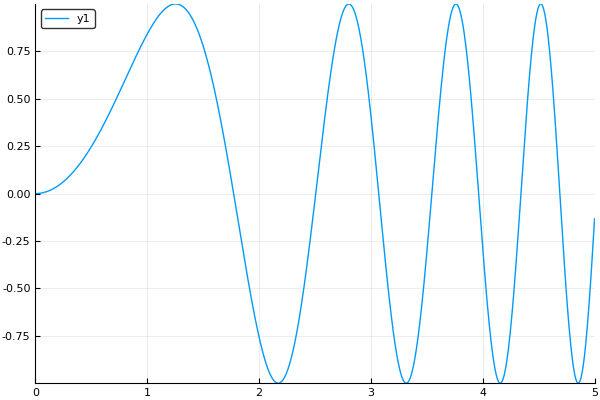

In [73]:
using Plots
pyplot() #plot using Matplotlib
x = linspace(0,5,1000)
plot(x, sin.(x.^2))

Note that the first plot while always take a few seconds to be drawn, a consequence of Julia's just in time compilation. Lots of other plot types are available

# Appendix 3: Advanced use of Julia and Notebooks
The following is just a sample of what can be done with Julia and notebooks. Feel free to explore by yourself any item of interest

### Notebooks
Jupyter notebooks have a lot of interesting hidden functionalities!

**Github and sharing**

If you save your .ipynb notebook file in a .git project, hosted on Github, you can easily visualize and share it online (in non-interactive mode).

For example, this notebook is available at https://github.com/sebmart/intro-julia-jupyter/blob/master/intro-julia-jupyter.ipynb

You can also use [Gist](https://gist.github.com) and [nbviewer](http://nbviewer.jupyter.org) to quickly share a notebook (for example to your advisor) without creating a git repo.

**Converting your notebook**

Jupyter notebooks are a popular format that can be converted to a variety of types of documents, depending on your needs:
- Latex
- HTML
- PDF
- Slides with Reveal.JS (used to present this notebook!)
- Markdown ...

These conversions use the [`nbconvert`](https://github.com/jupyter/nbconvert) command.

**Remote computing**

The Notebook system is a web interface. Notebooks can be run on another computer. This is useful if you want your code to run on a more powerful remote machine.

[Port-forwarding](https://help.ubuntu.com/community/SSH/OpenSSH/PortForwarding) through SSH is a good start for this.

**Advanced Markdown**

Jupyter text cells use Markdown for formatting. Markdown is an easy to use formatting language (a little like HTML or LaTeX in more simple). You can use the text of this notebook as an example, or learn more [here](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet).

Jupyter uses _Github flavored Markdown_, and is particularly good at displaying math and colored code. You can even include a video!

### Julia
We only presented a small subset of Julia functionalities. We list here of few interesting things you may not know.

**Using the command line from Julia**

You can run bash commands directly from Julia by starting the command with a semicolon: `;`

In [74]:
;ls

LICENSE
README.md
figures
optimization_jump_julia.ipynb
optimization_jump_julia.slides.html


**Unicode character** 

You can use unicode characters as part of variables and function names in Julia. You can use $\LaTeX$-style autocompletes in the Julia terminal or a Jupyter/IJulia code-cell to write them. Some of them are already defined Julia constants and functions
> Try to type `\pi<TAB>` in a cell.

In [75]:
π

π = 3.1415926535897...

In [76]:
"carrot" ∈ ["potato", "tomato", "carrot"]

true

**Juno**

Julia has a very nice and powerful text editor, [_Juno_](http://junolab.org), that is built on [Atom](https://atom.io). It is very similar to the Matlab interface or RStudio. Functionalities include:
- Autocomplete
- Integrated Plotting
- Debugging, Manual, ...

It is better suited for serious projects with several files, when an IJulia notebook is not enough.

**Advanced Julia functionalities**
Julia is a state-of-the-art programming language, with lots of useful functionalities, including:
- [Powerful Macros](http://docs.julialang.org/en/release-0.6/manual/metaprogramming/) (meta-programming)
- [Code testing](http://docs.julialang.org/en/release-0.6/stdlib/test/)
- [User-defined types](docs.julialang.org/en/release-0.6/manual/types/), that are as fast as built-in ones.
- [Package creation](http://docs.julialang.org/en/release-0.6/manual/modules/)
- A new [debugger](https://github.com/Keno/Gallium.jl) 

### Interesting Packages
Using the Package eco-system, there is almost nothing you cannot achieve:

-       Advanced Plotting   with [**Plots.jl**](https://juliaplots.github.io). Functionalities include 3D-plots, animated plots, stats plots, home-made plot "recipes" ...

- Call any python call using [**PyCall.jl**](https://github.com/JuliaPy/PyCall.jl). (you can also interacts with several other languages)

- Advanced graphs/networks algorithms with [**LightGraphs.jl**](https://github.com/JuliaGraphs/LightGraphs.jl)

- Applications in [**Finance**](https://github.com/JuliaQuant), [**Biology**](https://github.com/BioJulia/Bio.jl), [**Stats and Machine Learning**](http://juliastats.github.io), [**Optimization**](http://www.juliaopt.org) (including the great [**JuMP**](https://github.com/JuliaOpt/JuMP.jl) package!)

- Save and load your variables or environment to a file with [**JLD.jl**](https://github.com/JuliaIO/JLD.jl)

- More data structures in [**DataStructures.jl**](https://github.com/JuliaLang/DataStructures.jl)

- And a lot more in the **over 1200 registered packages**!